In [3]:
import os
from PIL import Image
import shutil
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Activation, UpSampling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects


In [4]:
# define where to find the images, base_dirs are those from the downloaded dataset, mask_dirs are those manually masked
base_dirs = ["./Training", "./Testing"]
mask_dirs = ["./Mask_Training", "./Mask_Testing"]
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# define lists
images = []
masks = []

# get images&masks and turn to np arrays
for base_dir, mask_dir in zip(base_dirs, mask_dirs):
    for category in categories:

        # define path to current category and directory
        img_category_path = os.path.join(base_dir, category)
        mask_category_path = os.path.join(mask_dir, category)
        
        # find masks name
        mask_files = set([os.path.splitext(f)[0] for f in os.listdir(mask_category_path)])

        for img_name in os.listdir(img_category_path):
            base_img_name = os.path.splitext(img_name)[0]  # remove extension from image name to check against mask

            if base_img_name in mask_files: # if has corresponding mask, perform
                 # construct mask path same as base path
                img_path = os.path.join(img_category_path, img_name)
                mask_name = base_img_name + '.png'
                mask_path = os.path.join(mask_category_path, mask_name) 
                
                # load and preprocess the image
                img = Image.open(img_path).resize((128, 128)) # normalise to faciliatet training and testing
                img = np.array(img)
                
                # load and preprocess the mask
                mask = Image.open(mask_path).resize((128, 128))
                mask = np.array(mask)

                if len(mask.shape) == 3:  # convert RGB to grayscale to simplify
                    mask = mask[:,:,0]
                
                mask = (mask > 0.5).astype(np.uint8) # convert to binary mask

                # store
                images.append(img)
                masks.append(mask)

# convert to array
images = np.array(images)
masks = np.array(masks)

# currently should ¡print 80
print(f"Loaded {len(images)} images and {len(masks)} masks.")

Loaded 80 images and 80 masks.


In [95]:
# EXAMPLE - Plot and image against the manually mask
"""
plt.figure(figsize=(4, 4))

copy_mask = (masks > 0.5).astype(np.uint8) # convert to binary mask
plt.imshow(images[80], cmap='gray')
#plt.imshow(copy_mask[46], cmap='Purples', alpha=0.5)

plt.axis('off')
plt.show()
"""


"\nplt.figure(figsize=(4, 4))\n\ncopy_mask = (masks > 0.5).astype(np.uint8) # convert to binary mask\nplt.imshow(images[80], cmap='gray')\n#plt.imshow(copy_mask[46], cmap='Purples', alpha=0.5)\n\nplt.axis('off')\nplt.show()\n"

In [5]:
# define angles manually
angles = np.array([1,1,0,1,1,1,1,3,3,1,2,2,1,1,1,1,1,1,1,1,3,3,1,1,2,1,1,1,1,0,3,3,3,3,3,3,3,3,3,3,2,0,3,1,3,1,1,3,1,2,2,3,1,1,3,3,3,1,3,3,1,1,1,1,0,2,1,3,1,1,0,2,2,2,0,0,2,2,2,2])

In [31]:
# define angles manually
angles = np.array([1,1,0,1,1,1,1,3,3,1,2,2,1,1,1,1,1,1,1,1,3,3,1,1,2,1,1,1,1,0,3,3,3,3,3,3,3,3,3,3,2,0,3,1,3,1,1,3,1,2,2,3,1,1,3,3,3,1,3,3,1,1,1,1,0,2,1,3,1,1,0,2,2,2,0,0,2,2,2,2])

# convert labels to one-hot encoding
angles = to_categorical(angles, num_classes=4)

# split data 
X_train_val, X_test, y_train_val, y_test = train_test_split(images, angles, test_size=0.2, random_state=42)

# val split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# data augmentation 
data_gen_train = ImageDataGenerator(
    horizontal_flip=True,  #  horizontal flipping
)

# no augmentation for validation data, only rescaling
data_gen_val = ImageDataGenerator()

# sequential model
def build_model(input_shape=(128, 128, 3), num_classes=4):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# generate new images
train_generator = data_gen_train.flow(X_train, y_train, batch_size=32)
val_generator = data_gen_val.flow(X_val, y_val, batch_size=32)

# build and compile the model
model_orientation = build_model(input_shape=X_train.shape[1:])
model_orientation.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model_orientation.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator  
)

# evaluate
test_loss, test_acc = model_orientation.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


Epoch 1/10
2/2 [==============================] - 1s 474ms/step - loss: 265.6045 - accuracy: 0.3750 - val_loss: 309.7887 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 0s 187ms/step - loss: 270.3131 - accuracy: 0.3958 - val_loss: 147.8478 - val_accuracy: 0.3125
Epoch 3/10
2/2 [==============================] - 0s 250ms/step - loss: 65.3753 - accuracy: 0.4583 - val_loss: 72.3329 - val_accuracy: 0.3750
Epoch 4/10
2/2 [==============================] - 0s 215ms/step - loss: 35.3105 - accuracy: 0.6042 - val_loss: 20.5755 - val_accuracy: 0.5625
Epoch 5/10
2/2 [==============================] - 0s 181ms/step - loss: 8.5193 - accuracy: 0.7083 - val_loss: 9.4425 - val_accuracy: 0.6250
Epoch 6/10
2/2 [==============================] - 0s 189ms/step - loss: 1.8703 - accuracy: 0.8958 - val_loss: 4.7149 - val_accuracy: 0.5000
Epoch 7/10
2/2 [==============================] - 0s 223ms/step - loss: 2.2998 - accuracy: 0.8333 - val_loss: 4.1721 - val_accuracy: 0.6875
Epoch 8/

In [6]:
# flatten angles to avoid an error
angles = angles.flatten() 

# initialise dictionary to group masks by orientation
masks_grouped_by_orientation = {0: [], 1: [], 2: [], 3: []}

# group masks by their orientation
for mask, angle in zip(masks, angles):
    angle_key = int(angle) 
    masks_grouped_by_orientation[angle_key].append(mask)

# initialise intersection masks
intersection_masks = {}

for orientation, grouped_masks in masks_grouped_by_orientation.items():
    if grouped_masks:  # check for masks
        # use first mask as starting point
        intersection_mask = grouped_masks[0].astype(np.bool_)
        
        # perform logical AND 
        for mask in grouped_masks[1:]:  # kip the first mask 
            intersection_mask = np.logical_and(intersection_mask, mask.astype(np.bool_))
        
        intersection_masks[orientation] = intersection_mask.astype(np.uint8) # convert to binary

(-0.5, 127.5, 127.5, -0.5)

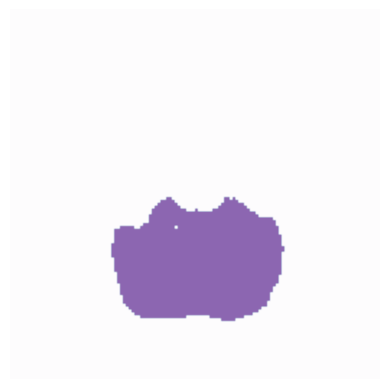

In [7]:
plt.imshow(intersection_masks[3], cmap='Purples', alpha=0.6)
plt.axis('Off')

In [69]:
"""
# defined simple U-NET network
def unet(input_size=(128, 128, 3)):
    
    inputs = Input(input_size) # define input

    # downsampling path
    # block1
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # block 2
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # upsampling
    
    up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2) # upconvolution

    merge1 = concatenate([conv1, up1], axis=3) # concatenate feature maps from down-sampling path and up-convolution

    # block 3
    convUp1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    convUp1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(convUp1)
    
    convFinal = Conv2D(1, 1, activation='sigmoid')(convUp1) # output layer

    model = Model(inputs=[inputs], outputs=[convFinal])
    
    return model


# compile
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# fit
model.fit(images, masks, batch_size=20, epochs=250, validation_split=0.1)
"""

"\n# defined simple U-NET network\ndef unet(input_size=(128, 128, 3)):\n    \n    inputs = Input(input_size) # define input\n\n    # downsampling path\n    # block1\n    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)\n    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)\n    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)\n    \n    # block 2\n    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)\n    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)\n    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)\n    \n    # upsampling\n    \n    up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv2) # upconvolution\n\n    merge1 = concatenate([conv1, up1], axis=3) # concatenate feature maps from down-sampling path and up-convolution\n\n    # block 3\n    convUp1 = Conv2D(64, 3, activation='relu', p

In [68]:
"""
# new directories
new_mask_dirs = ["./New_Mask_Training", "./New_Mask_Testing"]

# clear and copy existing masks
for mask_dir, new_mask_dir in zip(mask_dirs, new_mask_dirs):
    if os.path.exists(new_mask_dir):
        shutil.rmtree(new_mask_dir)  #  deletes contents
    shutil.copytree(mask_dir, new_mask_dir)  # copy contents from the original mask directory

# generate and save masks for missing images
for base_dir, new_mask_dir in zip(base_dirs, new_mask_dirs):
    for category in categories:

        # define path to current category and directory
        img_category_path = os.path.join(base_dir, category)
        new_mask_category_path = os.path.join(new_mask_dir, category)
        
        for img_name in os.listdir(img_category_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')) and not img_name.startswith('.'):
                img_path = os.path.join(img_category_path, img_name)
                new_mask_path = os.path.join(new_mask_category_path, img_name.replace('.jpg', '.png').replace('.jpeg', '.png'))  # ensure mask uses PNG format
                
                if not os.path.exists(new_mask_path):  # Only process images without an existing mask
                    
                    # process the image and predict the mask here
                    img = Image.open(img_path)
                    img = img.resize((128, 128))  # normalise
                    img_array = np.array(img) / 255.0
                    img_array = np.expand_dims(img_array, axis=0)  # expects a 4D tensor
                    
                    # predict mask
                    predicted_mask = model.predict(img_array)
                    predicted_mask = np.squeeze(predicted_mask)
                    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # convert to binary mask
                    
                    # save the mask
                    mask_image = Image.fromarray(predicted_mask * 255)
                    mask_image.save(new_mask_path)
                    print(f"Saved new mask to {new_mask_path}")
"""

'\n# new directories\nnew_mask_dirs = ["./New_Mask_Training", "./New_Mask_Testing"]\n\n# clear and copy existing masks\nfor mask_dir, new_mask_dir in zip(mask_dirs, new_mask_dirs):\n    if os.path.exists(new_mask_dir):\n        shutil.rmtree(new_mask_dir)  #  deletes contents\n    shutil.copytree(mask_dir, new_mask_dir)  # copy contents from the original mask directory\n\n# generate and save masks for missing images\nfor base_dir, new_mask_dir in zip(base_dirs, new_mask_dirs):\n    for category in categories:\n\n        # define path to current category and directory\n        img_category_path = os.path.join(base_dir, category)\n        new_mask_category_path = os.path.join(new_mask_dir, category)\n        \n        for img_name in os.listdir(img_category_path):\n            if img_name.lower().endswith((\'.png\', \'.jpg\', \'.jpeg\')) and not img_name.startswith(\'.\'):\n                img_path = os.path.join(img_category_path, img_name)\n                new_mask_path = os.path.join(

In [13]:
# define angles manually
angles = np.array([1,1,0,1,1,1,1,3,3,1,2,2,1,1,1,1,1,1,1,1,3,3,1,1,2,1,1,1,1,0,3,3,3,3,3,3,3,3,3,3,2,0,3,1,3,1,1,3,1,2,2,3,1,1,3,3,3,1,3,3,1,1,1,1,0,2,1,3,1,1,0,2,2,2,0,0,2,2,2,2])

In [9]:
# templates for training

# initalise templates
image_template_masks = []

# iterate for angles
for angle in angles:
    # retrieve orientation
    template_mask = intersection_masks[angle]
    
    # append to list
    image_template_masks.append(template_mask)

# convert
    
image_template_masks_array = np.array(image_template_masks)

In [14]:
from tensorflow.python.keras import losses
import tensorflow as tf
def unet(input_img_size=(128, 128, 3), input_mask_size=(128, 128, 1)):
    input_img = Input(input_img_size, name='img_input')
    input_mask = Input(input_mask_size, name='mask_input')
    
    inputs = concatenate([input_img, input_mask], axis=3)
    
    # downsampling path with batch normalisation and dropout
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # pool1 = Dropout(0.25)(pool1)  # dropout (regularisation)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # pool2 = Dropout(0.5)(pool2)  # increase dropout for deeper layers

    # bottleneck
    convB = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    convB = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(convB)

    # upsampling path
    up1 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(convB)
    merge1 = concatenate([conv2, up1], axis=3)
    # merge1 = Dropout(0.5)(merge1)

    convUp1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    convUp1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(convUp1)

    up2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(convUp1)
    merge2 = concatenate([conv1, up2], axis=3) 
    # merge2 = Dropout(0.25)(merge2)

    convUp2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    convUp2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(convUp2)

    convFinal = Conv2D(1, 1, activation='sigmoid', name='mask_output')(convUp2)

    model = Model(inputs=[input_img, input_mask], outputs=[convFinal])
    
    return model

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# define and compile
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train (fit)
model.fit([images, image_template_masks_array], masks, batch_size=20, epochs=10, validation_split=0.1)


Epoch 1/10
4/4 [==============================] - 11s 2s/step - loss: 0.5094 - accuracy: 0.7173 - val_loss: 0.7837 - val_accuracy: 0.6208
Epoch 2/10
4/4 [==============================] - 8s 2s/step - loss: 0.3416 - accuracy: 0.8692 - val_loss: 1.0596 - val_accuracy: 0.5089
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 0.3115 - accuracy: 0.8590 - val_loss: 0.8831 - val_accuracy: 0.5605
Epoch 4/10
4/4 [==============================] - 9s 2s/step - loss: 0.2945 - accuracy: 0.8726 - val_loss: 1.0222 - val_accuracy: 0.5837
Epoch 5/10
4/4 [==============================] - 8s 2s/step - loss: 0.2716 - accuracy: 0.8843 - val_loss: 0.7735 - val_accuracy: 0.5830
Epoch 6/10
4/4 [==============================] - 9s 2s/step - loss: 0.2724 - accuracy: 0.8817 - val_loss: 0.6055 - val_accuracy: 0.6302
Epoch 7/10
4/4 [==============================] - 10s 2s/step - loss: 0.2318 - accuracy: 0.9046 - val_loss: 0.5616 - val_accuracy: 0.7280
Epoch 8/10
4/4 [=======================

1/1 [==============================] - 0s 41ms/step


C:\Users\alejo\AppData\Local\Temp\ipykernel_15120\1899227259.py:46: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  processed_mask = get_largest_blob_mask(predicted_mask_binary)


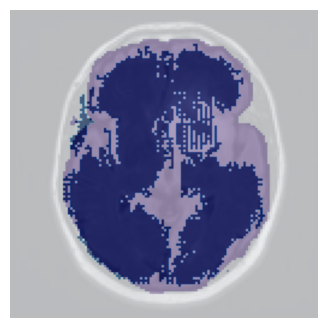

In [16]:
def get_largest_blob_mask(predicted_mask_binary):
    """
    processes the predicted binary mask to keep only the largest connected component (blob).
    
    parameters:
    - predicted_mask_binary: A binary mask as a 2D numpy array.
    
    returns:
    - binary mask as a 2D numpy array with only the largest blob.
    """
    # label the connected components
    labeled_array, num_features = label(predicted_mask_binary)

    # find objects will give us the slice indexes of each blob
    slice_indexes = find_objects(labeled_array)

    # identify largest blob
    largest_blob = 0
    largest_area = 0
    for i, slice_index in enumerate(slice_indexes):
        area = np.product([s.stop - s.start for s in slice_index])
        if area > largest_area:
            largest_area = area
            largest_blob = i + 1 

    # create a new mask with only the largest blob
    largest_blob_mask = np.zeros_like(predicted_mask_binary)
    largest_blob_mask[labeled_array == largest_blob] = 1

    return largest_blob_mask



# sample
sample_image = images[46]  
sample_template_mask = image_template_masks_array[46] 

# preprocess
sample_image_preprocessed = np.expand_dims(sample_image, axis=0) 
sample_template_mask_preprocessed = np.expand_dims(sample_template_mask, axis=0)  

# predict the mask using the model
predicted_mask = model.predict([sample_image_preprocessed, sample_template_mask_preprocessed])
predicted_mask_binary = (predicted_mask[0] > 0.5).astype(np.uint8) 
# Now get the binary mask with only the largest blob
processed_mask = get_largest_blob_mask(predicted_mask_binary)


# Visualization
plt.figure(figsize=(4, 4))
copy_mask = masks # convert to binary mask
plt.imshow(images[46], cmap='gray')
plt.imshow(copy_mask[46], cmap='Purples', alpha=0.5)
plt.imshow(processed_mask, cmap='Blues', alpha=0.5)  

plt.axis('off')  # Hide the axis
plt.show()



(-0.5, 127.5, 127.5, -0.5)

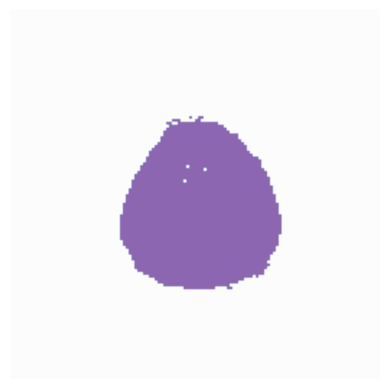

In [65]:
plt.imshow(template_mask, cmap='Purples', alpha=0.6)
plt.axis('Off')